In [1]:
from google.colab import drive
drive.mount('/content/drive')

! unzip -q '/content/drive/MyDrive/hateful_memes.zip' -d '/content/data'

Mounted at /content/drive


In [2]:
import spacy
import itertools
import pandas as pd
import seaborn as sns
from PIL import Image
from gensim.parsing.preprocessing import preprocess_string
from collections import Counter, OrderedDict
import matplotlib.pylab as plt
import plotly.express as px

pd.set_option('display.max_colwidth', None)
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## 1. Label-distribution of hateful/non-hateful for each dataset

In [3]:
train_path = "/content/data/hateful_memes/train.jsonl"
train_set = pd.read_json(train_path, lines=True)
train_value_count = train_set.label.value_counts()
train_non_hateful = train_value_count[0]
train_hateful = train_value_count[1]

dev_seen_path = "/content/data/hateful_memes/dev_seen.jsonl"
dev_seen_set = pd.read_json(dev_seen_path, lines=True)
dev_seen_value_count = dev_seen_set.label.value_counts()
dev_seen_non_hateful = dev_seen_value_count[0]
dev_seen_hateful = dev_seen_value_count[1]

dev_unseen_path = "/content/data/hateful_memes/dev_unseen.jsonl"
dev_unseen_set = pd.read_json(dev_unseen_path, lines=True)
dev_unseen_value_count = dev_unseen_set.label.value_counts()
dev_unseen_non_hateful = dev_unseen_value_count[0]
dev_unseen_hateful = dev_unseen_value_count[1]

test_seen_path = "/content/data/hateful_memes/test_seen.jsonl"
test_seen_set = pd.read_json(test_seen_path, lines=True)
test_seen_value_count = test_seen_set.label.value_counts()
test_seen_non_hateful = test_seen_value_count[0]
test_seen_hateful = test_seen_value_count[1]

test_unseen_path = "/content/data/hateful_memes/test_unseen.jsonl"
test_unseen_set = pd.read_json(test_unseen_path, lines=True)
test_unseen_value_count = test_unseen_set.label.value_counts()
test_unseen_non_hateful = test_unseen_value_count[0]
test_unseen_hateful = test_unseen_value_count[1]

results = {'Non_Hateful': [train_non_hateful, dev_seen_non_hateful, dev_unseen_non_hateful, test_seen_non_hateful, test_unseen_non_hateful],
            'Hateful': [train_hateful, dev_seen_hateful, dev_unseen_hateful, test_seen_hateful, test_unseen_hateful],
            'Total': [train_non_hateful+train_hateful, dev_seen_non_hateful+dev_seen_hateful, dev_unseen_non_hateful+dev_unseen_hateful,
                      test_seen_non_hateful+test_seen_hateful, test_unseen_non_hateful+test_unseen_hateful]}

pd.DataFrame(results, index=['train','dev seen','dev unseen','test seen','test unseen'])

Non_Hateful  Hateful  Total
train               5481     3019   8500
dev seen             253      247    500
dev unseen           340      200    540
test seen            510      490   1000
test unseen         1250      750   2000

## 2. Exploring the internal structure of the dataset and some hateful/non-hateful samples in training set

In [4]:
train_set.head()  # Display some non-hateful samples in training set

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                                     text  
0                        its their character not their color that matters  
1              don't be afraid to love again everyone is not like your ex  
2                                                putting bows on your pet  
3  i love everything and everybody! except for squirrels i hate squirrels  
4                     everybody loves chocolate chip cookies, even hitler

In [5]:
train_set.tail()  # Display some hateful samples in training set

id            img  label  \
8495  10423  img/10423.png      1   
8496  98203  img/98203.png      1   
8497  36947  img/36947.png      1   
8498  16492  img/16492.png      1   
8499  15937  img/15937.png      1   

                                                                                                                                    text  
8495                                                                                                   nobody wants to hang auschwitz me  
8496                                    when god grants you a child after 20 years of your marriage and israel bombs him few years later  
8497  gays on social media: equality! body positivity! love love love! gays in real life: there is no place for her in our social circle  
8498          having a bad day? you could be a siamese twin attached to a gay brother who has a date and you're the only one with an ass  
8499                                                        i hate muslims too they take their religion too seriously pathetic weaklings

## 3. The disrtibution of number of characters in each meme from training set

Text(0, 0.5, 'Frequency')

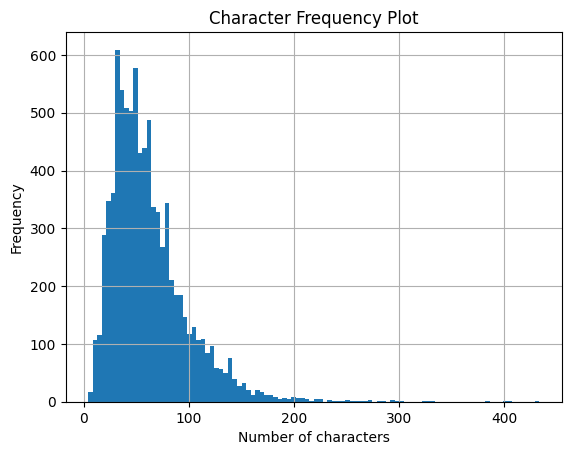

In [6]:
train_set['text'].str.len().hist(bins=100)
plt.title('Character Frequency Plot')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')

## 4. Exploring the most mentioned words of hateful/non-hateful memes in training set

In [7]:
# preprocess the text
train_set['text_preprocess'] = train_set.text.apply(preprocess_string)

# Get the counts of how many times each word shows up in training data
hateful = list(itertools.chain(*list(train_set.loc[train_set.label == 1, 'text_preprocess'])))
hateful_counts = Counter(hateful)
hateful_counts_desc = dict(OrderedDict(sorted(hateful_counts.items(), key=lambda x: x[1], reverse = True)))

non_hateful = list(itertools.chain(*list(train_set.loc[train_set.label == 0, 'text_preprocess'])))
non_hateful_counts = Counter(non_hateful)
non_hateful_counts_desc = dict(OrderedDict(sorted(non_hateful_counts.items(), key=lambda x: x[1], reverse = True)))

# Create the dataframes
hateful_df = pd.DataFrame.from_dict(hateful_counts_desc, orient='index')
hateful_df = hateful_df.reset_index()
hateful_df.rename(columns={0:'Counts', 'index': 'Word'}, inplace=True)

non_hateful_df = pd.DataFrame.from_dict(non_hateful_counts_desc, orient='index')
non_hateful_df = non_hateful_df.reset_index()
non_hateful_df.rename(columns={0:'Counts', 'index': 'Word'}, inplace=True)

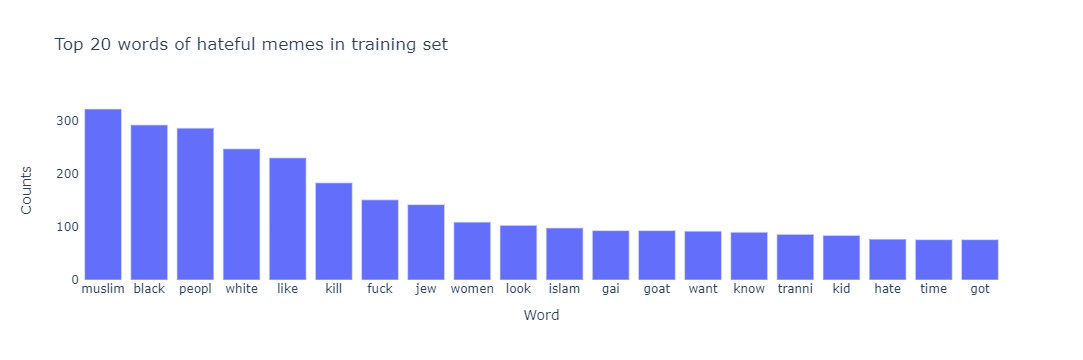

In [8]:
# Top 20 words of hateful memes in training set
hateful_bar = px.bar(hateful_df[:20], x='Word', y='Counts',
                     title='Top 20 words of hateful memes in training set')

hateful_bar.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)',
                           'paper_bgcolor':'rgba(0,0,0,0)'})
hateful_bar.show()

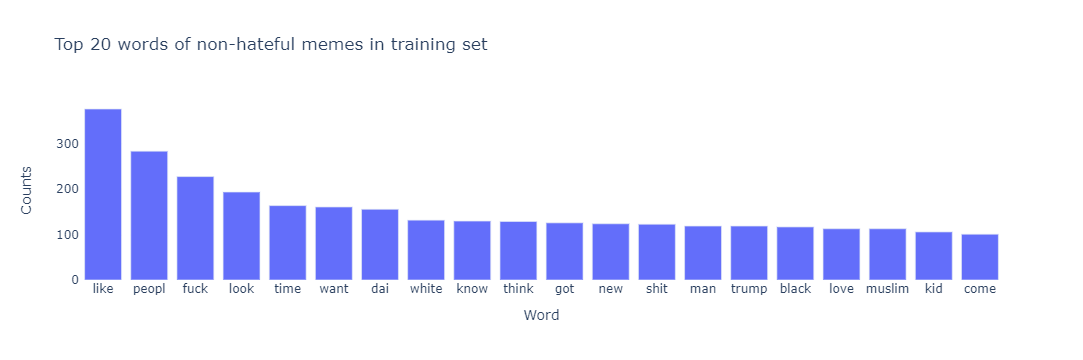

In [9]:
# Top 20 words of non-hateful memes in training set
non_hateful_bar = px.bar(non_hateful_df[:20], x='Word', y='Counts',
                         title='Top 20 words of non-hateful memes in training set')

non_hateful_bar.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)',
                              'paper_bgcolor':'rgba(0,0,0,0)'})
non_hateful_bar.show()

## 5. Display some images of hateful/non-hateful memes include the most mentioned words

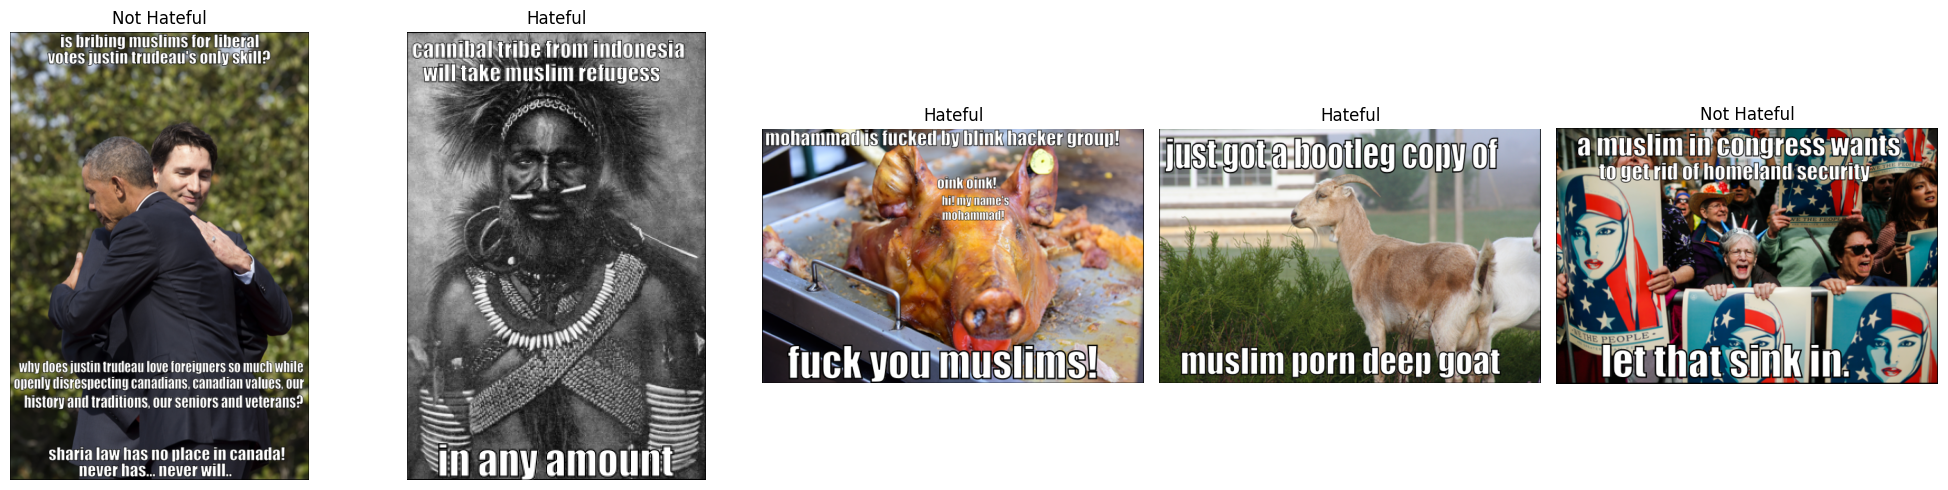

In [10]:
keyword = 'muslim'
y = train_set[train_set['text'].str.contains(keyword, case=False, na=False)]
img_paths =  y["img"][:5]
label = y["label"][:5]

img_list = [Image.open('/content/data/hateful_memes/' + img_path) for img_path in img_paths]
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
axs = axs.flatten()

for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.imshow(img_list[i])

    if label.iloc[i] == 0:
      ax.set_title("Not Hateful")
    else:
      ax.set_title("Hateful")

plt.tight_layout()

## 6. Exploring the most mentioned entities of hateful/non-hateful memes in training set

In [11]:
hateful_memes = train_set[train_set['label']==1]
non_hateful_memes = train_set[train_set['label']==0]

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

[Text(0.5, 1.0, 'Most mentioned entity types of non-hateful memes')]

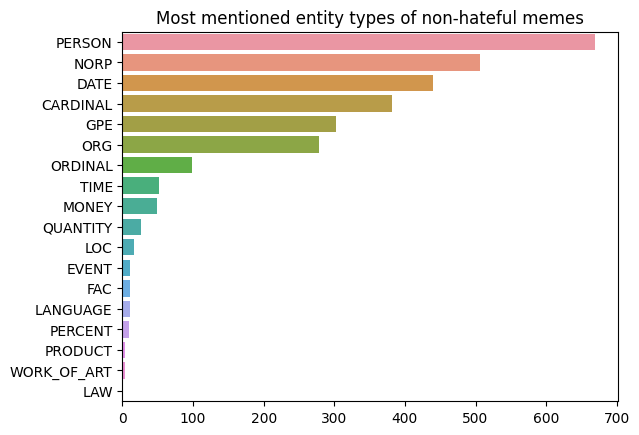

In [12]:
ent = non_hateful_memes['text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]
counter = Counter(ent)
count = counter.most_common()
x,y = map(list,zip(*count))
sns.barplot(x=y,y=x).set(title='Most mentioned entity types of non-hateful memes')

[Text(0.5, 1.0, 'Most mentioned entity types of hateful memes')]

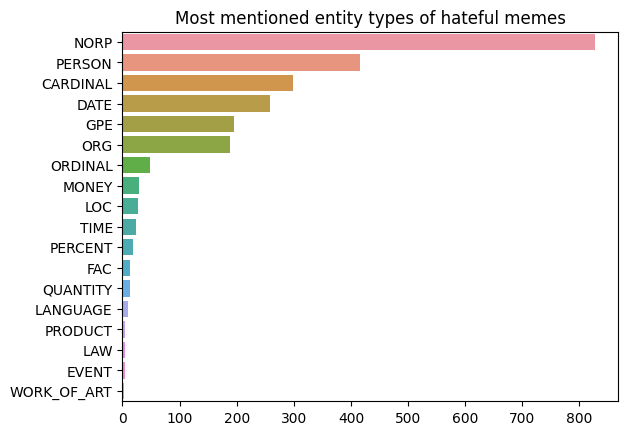

In [13]:
ent = hateful_memes['text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]
counter = Counter(ent)
count = counter.most_common()
x,y = map(list,zip(*count))
sns.barplot(x=y,y=x).set(title='Most mentioned entity types of hateful memes')

[Text(0.5, 1.0, 'Most mentioned NORP entities of hateful memes')]

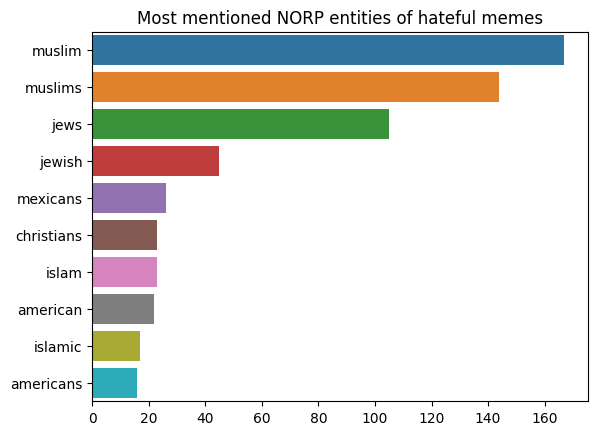

In [14]:
def ner(text, ent="NORP"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

norp = hateful_memes['text'].apply(lambda x: ner(x))
norp = [i for x in norp for i in x]
counter = Counter(norp)
x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x).set(title='Most mentioned NORP entities of hateful memes')

[Text(0.5, 1.0, 'Most mentioned PERSON entities of hateful memes')]

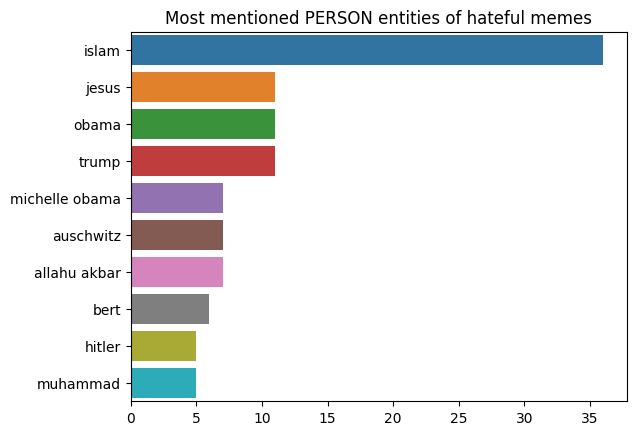

In [15]:
per = hateful_memes['text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)
x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x).set(title='Most mentioned PERSON entities of hateful memes')